In [215]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import optuna
import lightgbm as lgb

# データの読み込み
train = pd.read_csv("train.tsv", delimiter='\t', low_memory=True)
test = pd.read_csv("test.tsv", delimiter='\t', low_memory=True)

In [216]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

## 前処理

## 欠損値処理 + 文字列→カテゴリ変数→数値に変換
前処理がこのカテゴリ変数に変換だけだと、

RMSLE: 0.6145203911338316

In [217]:
# トレーニングデータとテストデータを結合
train_test_combine = pd.concat([train.drop(["price"], axis=1), test],axis=0).reset_index(drop=True)
target = np.log1p(train["price"].values)

#欠損値を処理
train_test_combine["category_name"].fillna("NaN")
train_test_combine["brand_name"].fillna("None")
train_test_combine["item_description"].fillna("No description yet")

# train_id, test_id は意味のない値だから削除
train_test_combine = train_test_combine.drop(["train_id", "test_id"], axis=1)

# カテゴリ変数に変換し、数値に変換
# cat.codesでカテゴリ変数を数値に変換　Optunaで最適化するためには数値に変換する必要がある
train_test_combine["item_condition_id"] = train_test_combine["item_condition_id"].astype("category").cat.codes
train_test_combine["category_name"] = train_test_combine["category_name"].astype("category").cat.codes 
train_test_combine["brand_name"] = train_test_combine["brand_name"].astype("category").cat.codes
train_test_combine["shipping"] = train_test_combine["shipping"].astype("category").cat.codes

In [218]:
train_test_combine.isnull().sum()

name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
item_description     6
dtype: int64

In [219]:
train_test_combine.dtypes

name                 object
item_condition_id      int8
category_name         int16
brand_name            int16
shipping               int8
item_description     object
dtype: object

In [220]:
#ブランド上位300個のみ抽出、それ以外はNoneに変換
drop_brand_list = train_test_combine["brand_name"].value_counts().index[300:]

def drop_brand(brand):
  if brand in drop_brand_list:
    return "None"
  else:
    return brand

# train_test_combine["brand_name"].replace(-1, "None", inplace=True)# -1をNoneに変換
train_test_combine["brand_name"].map(drop_brand) # map関数で適用、apply関数でも可 上位300個以外のブランド名はNoneに変換されている

0            -1
1          None
2          4588
3            -1
4            -1
           ... 
2175889      -1
2175890    2199
2175891      -1
2175892      -1
2175893      -1
Name: brand_name, Length: 2175894, dtype: object

試しに上位30個のブランド名を可視化

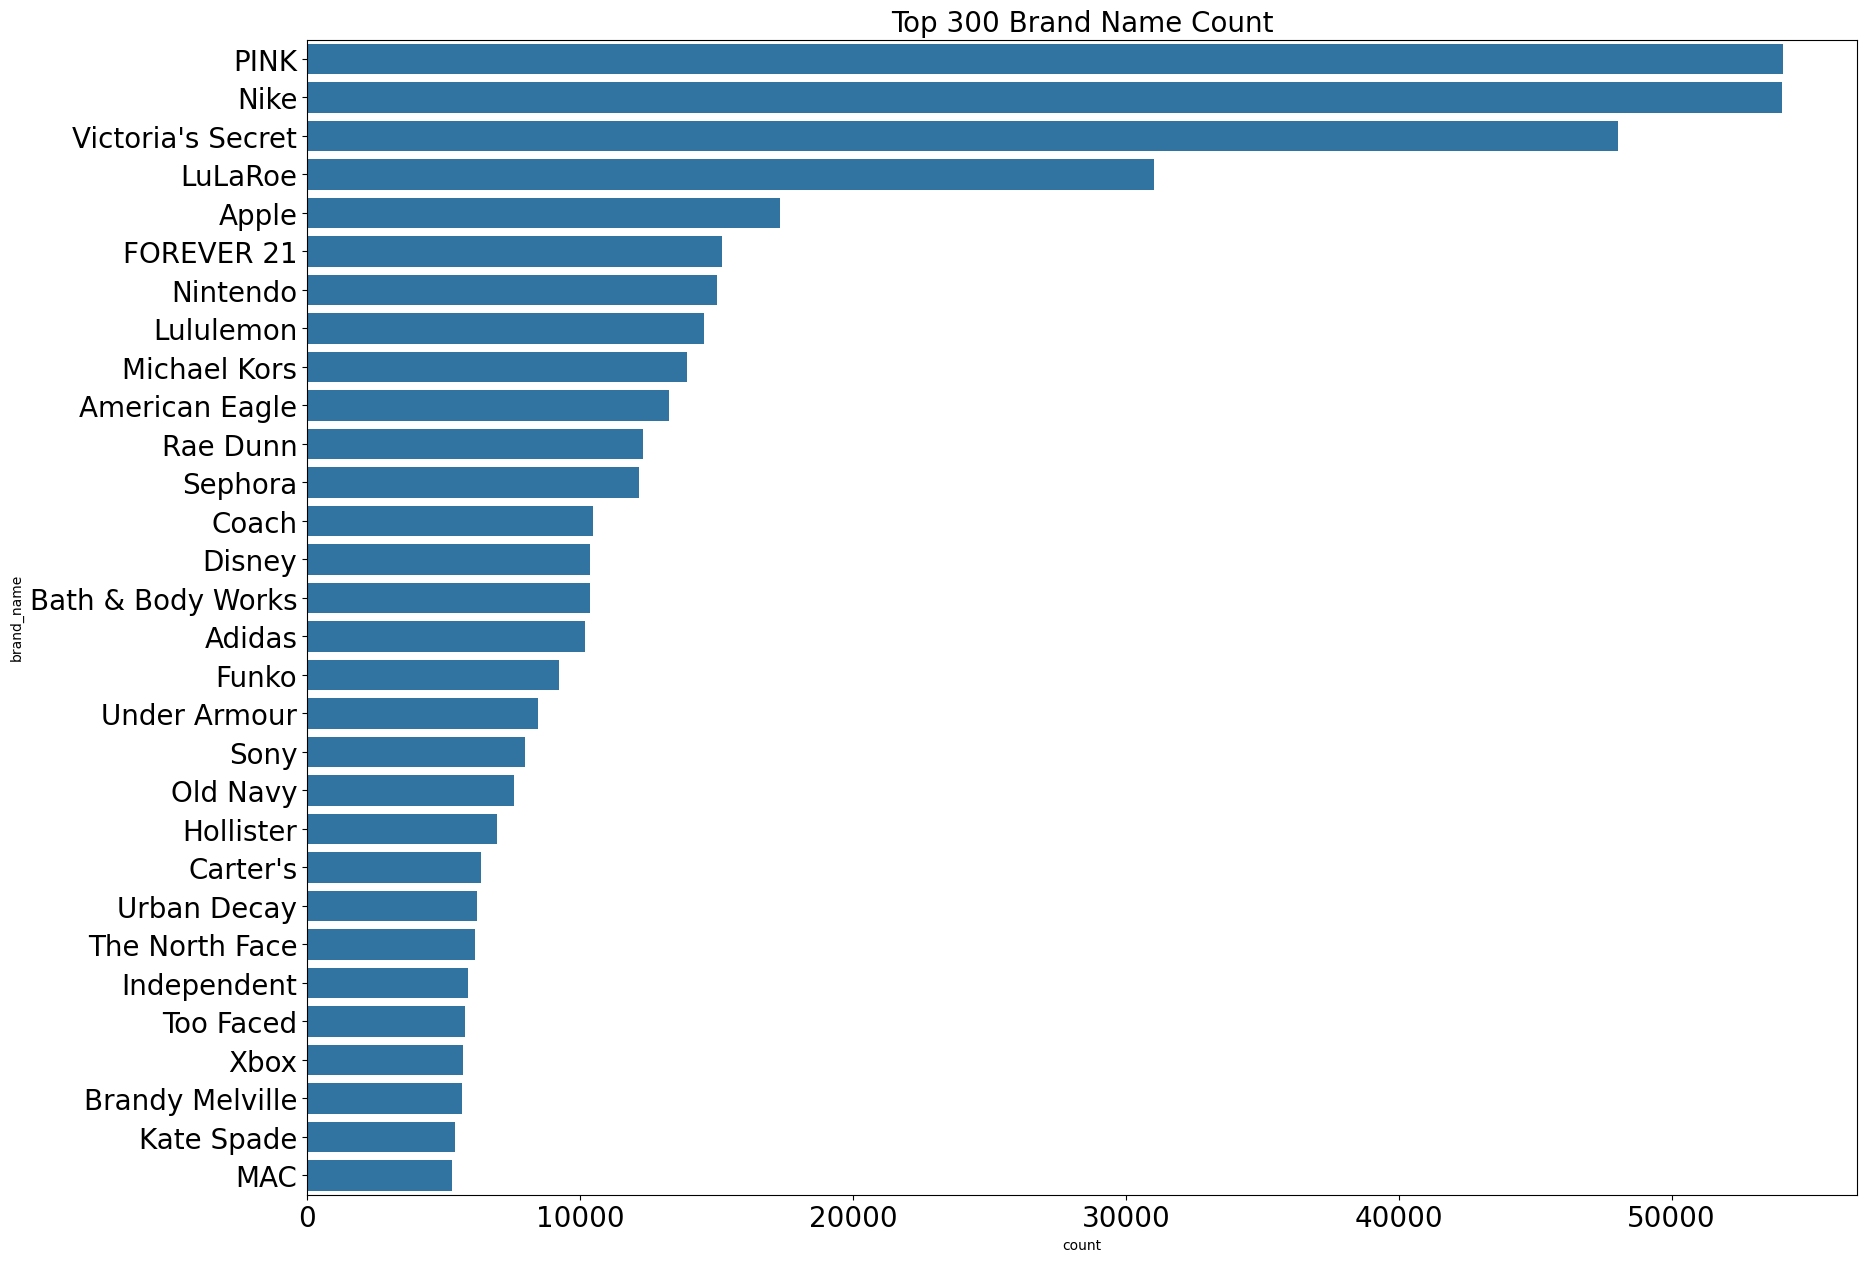

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt

# グラフのサイズを指定
plt.figure(figsize=(20, 15)) #(横, 縦)

# グラフを描画
top_30_brands = train["brand_name"].value_counts().nlargest(30)
sns.countplot(y=train["brand_name"], order=top_30_brands.index)

# ラベルのフォントサイズを大きくする
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# グラフのタイトルを設定
plt.title("Top 300 Brand Name Count", fontsize=20)

# グラフを表示
plt.show()

In [222]:
train_test_combine["item_description"].isnull().sum()

6

nameは単語をメインとした簡単な文章のため、
CountVectorizerを使用して、ベクトル変換を行う。

item_descriptionはnameよりも文章としての意味合いが強いため、
TfidfVectorizerを使用する。

In [223]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_name = CountVectorizer(min_df=10)
X_name = count_name.fit_transform(train_test_combine["name"])

# なんかエラーが出るから、一旦コメントアウト
# tfidf_description = TfidfVectorizer(max_features=200, stop_words="english", ngram_range=(1,3))
# X_description = tfidf_description.fit_transform(train_test_combine["item_description"])

各カテゴリーの最下位を抽出し、より詳細な分類を行う。

例)men > tops > shirts の場合は「shirts」を抽出

In [224]:
#各カテゴリーの末端を単語抽出
def pick_last_category(text):
  if text == "NaN":
    return "NaN"
  else:
    return str(text).split("/")[-1]

train_test_combine["last_category_name"] = train_test_combine["category_name"].map(pick_last_category)

# カテゴリ変数に変換し、数値に変換
train_test_combine["last_category_name"] = train_test_combine["last_category_name"].astype("category").cat.codes

In [225]:
train_test_combine.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,last_category_name
0,MLB Cincinnati Reds T Shirt Size XL,2,829,-1,1,No description yet,1122
1,Razer BlackWidow Chroma Keyboard,2,86,3889,0,This keyboard is in great condition and works ...,1156
2,AVA-VIV Blouse,0,1277,4588,1,Adorable top with a hint of lace and a key hol...,311
3,Leather Horse Statues,0,503,-1,1,New with tags. Leather horses. Retail for [rm]...,761
4,24K GOLD plated rose,0,1204,-1,0,Complete with certificate of authenticity,231


## 前処理終了

In [234]:
# 結合したデータを再びトレーニングデータとテストデータに分割
df_train = train_test_combine.iloc[:train.shape[0], :]
df_test = train_test_combine.iloc[train.shape[0]:, :]

df_test["name"].astype("category").cat.codes
df_test["item_description"].astype("category").cat.codes

# トレーニングデータとバリデーションデータに分割
X_train, X_valid, y_train, y_valid = train_test_split(df_train, train.price, test_size=0.2, random_state=42)

In [235]:
df_test.dtypes

name                  int32
item_condition_id      int8
category_name         int16
brand_name            int16
shipping               int8
item_description      int32
last_category_name    int16
dtype: object

## Oputunaでハイパーパラメータを最適化

In [236]:
# Optunaを使用してハイパーパラメータを最適化するための目的関数
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
    }
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    clf = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=1000)
    y_pred_valid = clf.predict(X_valid, num_iteration=clf.best_iteration)
    # マイナスの値を0に変換して、rmsleのエラーを回避
    y_pred_valid[y_pred_valid < 0] = 0
    score = mean_squared_log_error(y_valid, y_pred_valid)
    return score

# Oputunaはobject型のデータを扱えないので、カテゴリ変数を数値に変換
train_test_combine["name"] = train_test_combine["name"].astype("category").cat.codes 
train_test_combine["brand_name"] = train_test_combine["brand_name"].astype("category").cat.codes    
train_test_combine["item_description"] = train_test_combine["item_description"].astype("category").cat.codes

In [238]:
# Optunaを使用してハイパーパラメータを最適化する
study = optuna.create_study()
study.optimize(objective, n_trials=100)
params = study.best_params

[I 2024-06-23 02:03:48,184] A new study created in memory with name: no-name-65ddb2b7-82d9-4464-9ece-2f4e4b1c9ba4


/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:03:48,601] Trial 0 finished with value: 0.6793500886800149 and parameters: {'n_estimators': 53, 'max_depth': 2, 'learning_rate': 6.346278970935312e-05, 'num_leaves': 98}. Best is trial 0 with value: 0.6793500886800149.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:03:50,610] Trial 1 finished with value: 0.3918275265597743 and parameters: {'n_estimators': 65, 'max_depth': 24, 'learning_rate': 0.14481147330170419, 'num_leaves': 95}. Best is trial 1 with value: 0.3918275265597743.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:03:52,418] Trial 2 finished with value: 0.3783150879998849 and parameters: {'n_estimators': 79, 'max_depth': 26, 'learning_rate': 0.22225616598868417, 'num_leaves': 78}. Best is trial 2 with value: 0.3783150879998849.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:03:54,027] Trial 3 finished with value: 0.3725266898462412 and parameters: {'n_estimators': 52, 'max_depth': 25, 'learning_rate': 0.28641225674806253, 'num_leaves': 128}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:03:54,491] Trial 4 finished with value: 0.6796791088505889 and parameters: {'n_estimators': 32, 'max_depth': 32, 'learning_rate': 4.9535034451276275e-08, 'num_leaves': 13}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:03:57,584] Trial 5 finished with value: 0.6796782129267886 and parameters: {'n_estimators': 95, 'max_depth': 29, 'learning_rate': 3.002791210630939e-08, 'num_leaves': 119}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:03:57,912] Trial 6 finished with value: 0.6796790768533825 and parameters: {'n_estimators': 17, 'max_depth': 25, 'learning_rate': 7.617451735200363e-08, 'num_leaves': 31}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:03:58,482] Trial 7 finished with value: 0.679676718756129 and parameters: {'n_estimators': 34, 'max_depth': 14, 'learning_rate': 2.4820534556210115e-07, 'num_leaves': 37}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-23 02:03:59,324] Trial 8 finished with value: 0.4142599574630255 and parameters: {'n_estimators': 98, 'max_depth': 4, 'learning_rate': 0.3505967221095911, 'num_leaves': 58}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:03:59,660] Trial 9 finished with value: 0.6796581502129437 and parameters: {'n_estimators': 54, 'max_depth': 2, 'learning_rate': 4.014441025709325e-06, 'num_leaves': 36}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-06-23 02:03:59,846] Trial 10 finished with value: 0.675871477397773 and parameters: {'n_estimators': 2, 'max_depth': 18, 'learning_rate': 0.004332603971291777, '

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:01,572] Trial 11 finished with value: 0.5807478355416414 and parameters: {'n_estimators': 72, 'max_depth': 19, 'learning_rate': 0.006304509992465005, 'num_leaves': 77}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:03,321] Trial 12 finished with value: 0.5199823773221679 and parameters: {'n_estimators': 78, 'max_depth': 25, 'learning_rate': 0.015251528740537573, 'num_leaves': 70}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:04,954] Trial 13 finished with value: 0.42838543172413485 and parameters: {'n_estimators': 79, 'max_depth': 13, 'learning_rate': 0.8911035954448209, 'num_leaves': 94}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:06,142] Trial 14 finished with value: 0.6723457751421066 and parameters: {'n_estimators': 40, 'max_depth': 21, 'learning_rate': 0.00043719787313424623, 'num_leaves': 110}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:07,429] Trial 15 finished with value: 0.4730357394124452 and parameters: {'n_estimators': 63, 'max_depth': 30, 'learning_rate': 0.041933260211723035, 'num_leaves': 59}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:09,487] Trial 16 finished with value: 0.6587106806261204 and parameters: {'n_estimators': 85, 'max_depth': 28, 'learning_rate': 0.0006738541691478998, 'num_leaves': 84}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-06-23 02:04:09,728] Trial 17 finished with value: 0.6796041690295962 and parameters: {'n_estimators': 44, 'max_depth': 22, 'learning_rate': 3.4698949015202874e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:12,340] Trial 18 finished with value: 0.41470243626315884 and parameters: {'n_estimators': 89, 'max_depth': 14, 'learning_rate': 0.05201537812269423, 'num_leaves': 111}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:12,802] Trial 19 finished with value: 0.6716729409222414 and parameters: {'n_estimators': 23, 'max_depth': 9, 'learning_rate': 0.0010331680971396625, 'num_leaves': 47}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:14,971] Trial 20 finished with value: 0.6794755453493644 and parameters: {'n_estimators': 69, 'max_depth': 27, 'learning_rate': 6.558119837140228e-06, 'num_leaves': 127}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:16,669] Trial 21 finished with value: 0.39228846841061144 and parameters: {'n_estimators': 64, 'max_depth': 24, 'learning_rate': 0.14793929592506197, 'num_leaves': 91}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:18,115] Trial 22 finished with value: 0.4333833963399743 and parameters: {'n_estimators': 62, 'max_depth': 22, 'learning_rate': 0.9361265489095439, 'num_leaves': 104}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:19,381] Trial 23 finished with value: 0.3981025744222314 and parameters: {'n_estimators': 51, 'max_depth': 26, 'learning_rate': 0.1656257362237199, 'num_leaves': 81}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:20,987] Trial 24 finished with value: 0.4868082456567461 and parameters: {'n_estimators': 75, 'max_depth': 32, 'learning_rate': 0.026879471786675317, 'num_leaves': 67}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:23,482] Trial 25 finished with value: 0.5894161538299963 and parameters: {'n_estimators': 85, 'max_depth': 20, 'learning_rate': 0.004009904710541148, 'num_leaves': 114}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:24,969] Trial 26 finished with value: 0.4073489307203971 and parameters: {'n_estimators': 57, 'max_depth': 16, 'learning_rate': 0.1115675086830333, 'num_leaves': 89}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:26,192] Trial 27 finished with value: 0.37495434012055945 and parameters: {'n_estimators': 47, 'max_depth': 23, 'learning_rate': 0.44406428493400685, 'num_leaves': 105}. Best is trial 3 with value: 0.3725266898462412.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:27,383] Trial 28 finished with value: 0.37224225944772005 and parameters: {'n_estimators': 44, 'max_depth': 23, 'learning_rate': 0.3766650444348127, 'num_leaves': 104}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:28,692] Trial 29 finished with value: 0.6772969913395814 and parameters: {'n_estimators': 46, 'max_depth': 23, 'learning_rate': 0.00012040780971280528, 'num_leaves': 106}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:29,714] Trial 30 finished with value: 0.5808002239026707 and parameters: {'n_estimators': 32, 'max_depth': 16, 'learning_rate': 0.012078683562847036, 'num_leaves': 120}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:30,764] Trial 31 finished with value: 0.3780901453128225 and parameters: {'n_estimators': 39, 'max_depth': 27, 'learning_rate': 0.4095765156753713, 'num_leaves': 100}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:31,789] Trial 32 finished with value: 0.3934644976489009 and parameters: {'n_estimators': 40, 'max_depth': 29, 'learning_rate': 0.7198096263234457, 'num_leaves': 104}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:33,001] Trial 33 finished with value: 0.37561727253089805 and parameters: {'n_estimators': 47, 'max_depth': 24, 'learning_rate': 0.36187947736677534, 'num_leaves': 99}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:34,745] Trial 34 finished with value: 0.43896040361104 and parameters: {'n_estimators': 48, 'max_depth': 23, 'learning_rate': 0.06243930380183219, 'num_leaves': 117}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:36,175] Trial 35 finished with value: 0.37796719029849624 and parameters: {'n_estimators': 55, 'max_depth': 21, 'learning_rate': 0.2567813442478138, 'num_leaves': 99}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:36,968] Trial 36 finished with value: 0.4777884553761536 and parameters: {'n_estimators': 23, 'max_depth': 24, 'learning_rate': 0.072380509378579, 'num_leaves': 124}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:37,860] Trial 37 finished with value: 0.5595898144915655 and parameters: {'n_estimators': 28, 'max_depth': 19, 'learning_rate': 0.019333903524884753, 'num_leaves': 114}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:39,112] Trial 38 finished with value: 0.6438847272952526 and parameters: {'n_estimators': 49, 'max_depth': 31, 'learning_rate': 0.0021733377280781694, 'num_leaves': 86}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:40,047] Trial 39 finished with value: 0.3839390581876948 and parameters: {'n_estimators': 36, 'max_depth': 25, 'learning_rate': 0.37512068092403383, 'num_leaves': 95}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:41,755] Trial 40 finished with value: 0.6796792267918634 and parameters: {'n_estimators': 56, 'max_depth': 27, 'learning_rate': 1.0010778944109903e-08, 'num_leaves': 120}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:43,290] Trial 41 finished with value: 0.3810455216234538 and parameters: {'n_estimators': 56, 'max_depth': 21, 'learning_rate': 0.20425854505405278, 'num_leaves': 100}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:44,452] Trial 42 finished with value: 0.38242468698331517 and parameters: {'n_estimators': 43, 'max_depth': 20, 'learning_rate': 0.2823377745058477, 'num_leaves': 98}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:46,252] Trial 43 finished with value: 0.40614426101810785 and parameters: {'n_estimators': 60, 'max_depth': 17, 'learning_rate': 0.09502912556076497, 'num_leaves': 109}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:47,292] Trial 44 finished with value: 0.3783604816809264 and parameters: {'n_estimators': 49, 'max_depth': 23, 'learning_rate': 0.5123413795698167, 'num_leaves': 75}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:49,453] Trial 45 finished with value: 0.6796476496775787 and parameters: {'n_estimators': 69, 'max_depth': 25, 'learning_rate': 1.0223632174498211e-06, 'num_leaves': 127}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:50,927] Trial 46 finished with value: 0.5765772014266961 and parameters: {'n_estimators': 53, 'max_depth': 22, 'learning_rate': 0.008207928371151772, 'num_leaves': 102}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:51,793] Trial 47 finished with value: 0.5207193023438718 and parameters: {'n_estimators': 36, 'max_depth': 18, 'learning_rate': 0.03188402976820086, 'num_leaves': 74}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:52,123] Trial 48 finished with value: 0.46557173022898596 and parameters: {'n_estimators': 9, 'max_depth': 29, 'learning_rate': 0.24427739675518112, 'num_leaves': 89}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:53,119] Trial 49 finished with value: 0.39927517867791046 and parameters: {'n_estimators': 43, 'max_depth': 11, 'learning_rate': 0.76523317882804, 'num_leaves': 94}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:53,730] Trial 50 finished with value: 0.4719661816139082 and parameters: {'n_estimators': 28, 'max_depth': 21, 'learning_rate': 0.10188381195456825, 'num_leaves': 55}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:54,805] Trial 51 finished with value: 0.38182779110881054 and parameters: {'n_estimators': 40, 'max_depth': 27, 'learning_rate': 0.35675762085155566, 'num_leaves': 99}. Best is trial 28 with value: 0.37224225944772005.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:56,328] Trial 52 finished with value: 0.3701043780076564 and parameters: {'n_estimators': 59, 'max_depth': 26, 'learning_rate': 0.3905120251777516, 'num_leaves': 108}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:58,070] Trial 53 finished with value: 0.45348247824202514 and parameters: {'n_estimators': 59, 'max_depth': 26, 'learning_rate': 0.04287873268169647, 'num_leaves': 109}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:04:59,390] Trial 54 finished with value: 0.43957657459949334 and parameters: {'n_estimators': 52, 'max_depth': 24, 'learning_rate': 0.9916692259968434, 'num_leaves': 115}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:01,458] Trial 55 finished with value: 0.38146462053872215 and parameters: {'n_estimators': 66, 'max_depth': 25, 'learning_rate': 0.15231284573687737, 'num_leaves': 122}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:01,988] Trial 56 finished with value: 0.41507312555110676 and parameters: {'n_estimators': 46, 'max_depth': 23, 'learning_rate': 0.41388750958764725, 'num_leaves': 20}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:03,554] Trial 57 finished with value: 0.5095861990392757 and parameters: {'n_estimators': 53, 'max_depth': 20, 'learning_rate': 0.021050684334270334, 'num_leaves': 110}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:04,978] Trial 58 finished with value: 0.38542526599594357 and parameters: {'n_estimators': 60, 'max_depth': 28, 'learning_rate': 0.2081542018392845, 'num_leaves': 82}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:06,980] Trial 59 finished with value: 0.4153870214496172 and parameters: {'n_estimators': 68, 'max_depth': 30, 'learning_rate': 0.06947306443509375, 'num_leaves': 106}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:08,187] Trial 60 finished with value: 0.6757620127858958 and parameters: {'n_estimators': 45, 'max_depth': 22, 'learning_rate': 0.00020939996534931313, 'num_leaves': 95}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:09,248] Trial 61 finished with value: 0.3769522296481922 and parameters: {'n_estimators': 41, 'max_depth': 26, 'learning_rate': 0.4530057329088919, 'num_leaves': 100}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:10,590] Trial 62 finished with value: 0.37755447948936566 and parameters: {'n_estimators': 49, 'max_depth': 26, 'learning_rate': 0.43478538363442726, 'num_leaves': 92}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:11,557] Trial 63 finished with value: 0.679348695922751 and parameters: {'n_estimators': 37, 'max_depth': 26, 'learning_rate': 2.1307005374573112e-05, 'num_leaves': 86}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:12,685] Trial 64 finished with value: 0.37979359476581886 and parameters: {'n_estimators': 49, 'max_depth': 26, 'learning_rate': 0.577512367712345, 'num_leaves': 90}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-23 02:05:13,236] Trial 65 finished with value: 0.4739031385018825 and parameters: {'n_estimators': 42, 'max_depth': 5, 'learning_rate': 0.1309762645955104, 'num_leaves': 105}. Best is trial 52 with value: 0.3701043780076564.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:14,173] Trial 66 finished with value: 0.42492791634072086 and parameters: {'n_estimators': 33, 'max_depth': 24, 'learning_rate': 0.9959805676374563, 'num_leaves': 113}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:15,143] Trial 67 finished with value: 0.49217764749277265 and parameters: {'n_estimators': 29, 'max_depth': 28, 'learning_rate': 0.047302993583863924, 'num_leaves': 116}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:16,182] Trial 68 finished with value: 0.37908754796090877 and parameters: {'n_estimators': 48, 'max_depth': 29, 'learning_rate': 0.5301548569165653, 'num_leaves': 79}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:17,592] Trial 69 finished with value: 0.3953458156077178 and parameters: {'n_estimators': 52, 'max_depth': 30, 'learning_rate': 0.1628701274361053, 'num_leaves': 92}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:18,848] Trial 70 finished with value: 0.38074737926254343 and parameters: {'n_estimators': 45, 'max_depth': 24, 'learning_rate': 0.30729870814022703, 'num_leaves': 106}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:20,299] Trial 71 finished with value: 0.37883570136952194 and parameters: {'n_estimators': 56, 'max_depth': 25, 'learning_rate': 0.25554568811600803, 'num_leaves': 97}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:21,987] Trial 72 finished with value: 0.4122846487048481 and parameters: {'n_estimators': 59, 'max_depth': 27, 'learning_rate': 0.08598135329270096, 'num_leaves': 101}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:23,253] Trial 73 finished with value: 0.3829372988033732 and parameters: {'n_estimators': 50, 'max_depth': 23, 'learning_rate': 0.6137587817084715, 'num_leaves': 109}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:25,056] Trial 74 finished with value: 0.3739646914225072 and parameters: {'n_estimators': 62, 'max_depth': 21, 'learning_rate': 0.22440564488936418, 'num_leaves': 118}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:27,048] Trial 75 finished with value: 0.38833464658461053 and parameters: {'n_estimators': 64, 'max_depth': 28, 'learning_rate': 0.12803353463827932, 'num_leaves': 119}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:28,340] Trial 76 finished with value: 0.5665731603888999 and parameters: {'n_estimators': 39, 'max_depth': 25, 'learning_rate': 0.012123969418775119, 'num_leaves': 128}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:30,260] Trial 77 finished with value: 0.3746360731419011 and parameters: {'n_estimators': 75, 'max_depth': 22, 'learning_rate': 0.49449388194351473, 'num_leaves': 118}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:32,638] Trial 78 finished with value: 0.4148428950672898 and parameters: {'n_estimators': 75, 'max_depth': 22, 'learning_rate': 0.05924209572446039, 'num_leaves': 122}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:35,578] Trial 79 finished with value: 0.4497220023865024 and parameters: {'n_estimators': 93, 'max_depth': 20, 'learning_rate': 0.027563586364076718, 'num_leaves': 125}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:37,444] Trial 80 finished with value: 0.3915090517161656 and parameters: {'n_estimators': 74, 'max_depth': 19, 'learning_rate': 0.6324443372454838, 'num_leaves': 118}. Best is trial 52 with value: 0.3701043780076564.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:39,558] Trial 81 finished with value: 0.36682692742310397 and parameters: {'n_estimators': 85, 'max_depth': 26, 'learning_rate': 0.3928694122879075, 'num_leaves': 112}. Best is trial 81 with value: 0.36682692742310397.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:41,931] Trial 82 finished with value: 0.6796734368131503 and parameters: {'n_estimators': 83, 'max_depth': 22, 'learning_rate': 1.6561316572613867e-07, 'num_leaves': 113}. Best is trial 81 with value: 0.36682692742310397.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:44,637] Trial 83 finished with value: 0.3629393488318061 and parameters: {'n_estimators': 100, 'max_depth': 24, 'learning_rate': 0.21439232409957265, 'num_leaves': 122}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:47,456] Trial 84 finished with value: 0.3672067150475844 and parameters: {'n_estimators': 97, 'max_depth': 24, 'learning_rate': 0.16998175212146727, 'num_leaves': 122}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:50,448] Trial 85 finished with value: 0.3666245298144366 and parameters: {'n_estimators': 98, 'max_depth': 21, 'learning_rate': 0.16919454778656856, 'num_leaves': 121}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:53,545] Trial 86 finished with value: 0.3812294435795047 and parameters: {'n_estimators': 99, 'max_depth': 21, 'learning_rate': 0.10003024995431897, 'num_leaves': 123}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:56,318] Trial 87 finished with value: 0.365136389822955 and parameters: {'n_estimators': 96, 'max_depth': 23, 'learning_rate': 0.19774175285091358, 'num_leaves': 128}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:05:59,046] Trial 88 finished with value: 0.366179948584489 and parameters: {'n_estimators': 95, 'max_depth': 19, 'learning_rate': 0.19245275188836547, 'num_leaves': 126}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:01,858] Trial 89 finished with value: 0.3677768909274093 and parameters: {'n_estimators': 94, 'max_depth': 18, 'learning_rate': 0.15741873392732608, 'num_leaves': 128}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:04,860] Trial 90 finished with value: 0.4279377524094039 and parameters: {'n_estimators': 93, 'max_depth': 18, 'learning_rate': 0.037985729521769436, 'num_leaves': 128}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:07,644] Trial 91 finished with value: 0.3672041694219584 and parameters: {'n_estimators': 96, 'max_depth': 16, 'learning_rate': 0.16934302168226945, 'num_leaves': 125}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:10,428] Trial 92 finished with value: 0.367768881146433 and parameters: {'n_estimators': 96, 'max_depth': 16, 'learning_rate': 0.16099379405217912, 'num_leaves': 124}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:13,240] Trial 93 finished with value: 0.3717694199020546 and parameters: {'n_estimators': 96, 'max_depth': 16, 'learning_rate': 0.14769816206465072, 'num_leaves': 125}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:15,995] Trial 94 finished with value: 0.3923579071393528 and parameters: {'n_estimators': 89, 'max_depth': 14, 'learning_rate': 0.07983390457064658, 'num_leaves': 121}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:18,880] Trial 95 finished with value: 0.41270137302622767 and parameters: {'n_estimators': 90, 'max_depth': 15, 'learning_rate': 0.05060268448399506, 'num_leaves': 126}. Best is trial 83 with value: 0.3629393488318061.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:21,570] Trial 96 finished with value: 0.3625203777955483 and parameters: {'n_estimators': 97, 'max_depth': 17, 'learning_rate': 0.21331808576096079, 'num_leaves': 124}. Best is trial 96 with value: 0.3625203777955483.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:24,409] Trial 97 finished with value: 0.3668463944556472 and parameters: {'n_estimators': 100, 'max_depth': 17, 'learning_rate': 0.17659878102563217, 'num_leaves': 123}. Best is trial 96 with value: 0.3625203777955483.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:27,406] Trial 98 finished with value: 0.5432160079158712 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.006700476513736107, 'num_leaves': 123}. Best is trial 96 with value: 0.3625203777955483.
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_12672/197961078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


[I 2024-06-23 02:06:30,530] Trial 99 finished with value: 0.5919701203231983 and parameters: {'n_estimators': 97, 'max_depth': 17, 'learning_rate': 0.003321598340869148, 'num_leaves': 121}. Best is trial 96 with value: 0.3625203777955483.


### 最適なパラメータ

In [239]:
params

{'n_estimators': 97,
 'max_depth': 17,
 'learning_rate': 0.21331808576096079,
 'num_leaves': 124}

In [241]:
# 最適なパラメータでモデルをトレーニングする
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
clf = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=1000) #paramsは先ほどの最適化で得られたパラメータ

/Users/1612h/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 7
[LightGBM] [Info] Start training from score 26.697437


In [242]:
from sklearn.metrics import mean_squared_log_error # RMSLEの計算ができる
# モデルを評価する
y_pred_valid = clf.predict(X_valid, num_iteration=clf.best_iteration)
# マイナスの値を0に変換して、rmsleのエラーを回避
y_pred_valid[y_pred_valid < 0] = 0

# モデルを評価する
score = np.sqrt(mean_squared_log_error(y_valid, y_pred_valid))
print(f"RMSLE: {score}") # 1回目(カテゴリ変数にしただけ)は0.6145203911338316

RMSLE: 0.6020966515398904


## この後のファイルの出力はまだうまくできてない

In [243]:
df_test = df_test.drop(["last_category_name"], axis=1)
df_test

,name,item_condition_id,category_name,brand_name,shipping,item_description
1482535,323913,0,1205,0,1,1395407
1482536,65692,0,899,0,1,95840
1482537,410310,0,1000,1095,1,383740
1482538,544668,1,1256,0,0,34210
1482539,810652,2,860,0,1,1316300
...,...,...,...,...,...,...
2175889,1264999,0,503,0,0,632887
2175890,707426,0,31,2200,1,829165
2175891,597767,0,79,0,1,1152977
2175892,669290,1,1274,0,0,633654


In [246]:
# 作成したランダムフォレストのモデル「clf」に「df_test」を入れて予測する
preds = clf.predict(df_test)

# 予測値 predsをnp.exp()で処理
np.exp(preds)

# Numpy配列からpandasシリーズへ変換
preds = pd.Series(np.exp(preds))

# テストデータのIDと予測値を連結
submit = pd.concat([test.id, preds], axis=1)

# カラム名をメルカリの提出指定の名前をつける
submit.columns = ['test_id', 'price']

# 提出ファイルとしてCSVへ書き出し
submit.to_csv('submit_ligthtgbm.csv', index=False)


[LightGBM] [Fatal] The number of features in data (6) is not the same as it was in training data (7).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (6) is not the same as it was in training data (7).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.